In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss,f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import KFold
import tqdm.notebook as tq

val_data = pd.read_csv('https://raw.githubusercontent.com/hendrSet312/Fiction-Book-genre-classification/refs/heads/main/data/val.csv',index_col = 'book_title')
train_data = pd.read_csv('https://raw.githubusercontent.com/hendrSet312/Fiction-Book-genre-classification/refs/heads/main/data/train.csv',index_col = 'book_title')

device = torch.device('cuda')

In [2]:
class bookDataset(Dataset):
    def __init__(self,data, tokenizer, max_len, labels):
        self.tokenizer = tokenizer
        self.data = data
        self.book_details = list(data['book_details'])
        self.labels = self.data[labels].values
        self.max_len = max_len
        
    def __len__(self):
        return len(self.book_details)

    def __getitem__(self,index):
        book_desc = str(self.book_details[index])
        book_desc = " ".join(book_desc.split())
        inputs = self.tokenizer.encode_plus(
            book_desc,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            return_token_type_ids= True,
            truncation = True,
            return_attention_mask =True,
            return_tensors = 'pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'labels': torch.FloatTensor(self.labels[index]),
            'book_details': book_desc
        }
        

In [28]:
max_length = 75
cols_list = list(train_data.columns[1:])
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:

train_dataset = bookDataset(train_data, tokenizer,max_length,cols_list)
validation_dataset = bookDataset(val_data, tokenizer,max_length,cols_list)
validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)

In [30]:
train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True,num_workers=4, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)

In [64]:
class RobertaModel(torch.nn.Module):
    def __init__(self):
        super(RobertaModel, self).__init__()
        self.model = AutoModel.from_pretrained("google-bert/bert-base-uncased", return_dict=True)
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(768, 312)
        
        self.dropout2 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(312, 128)

        self.dropout3 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(128, 5)

        self.leakyrelu = nn.LeakyReLU(negative_slope=0.015)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(312)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        output = output.last_hidden_state[:, 0, :]

        output = self.bn1(output)
        output = self.leakyrelu(output)
        output = self.dropout1(output)
        output = self.linear1(output)
        
        output = self.bn2(output)
        output = self.leakyrelu(output)
        output = self.dropout2(output)
        output = self.linear2(output)

        output = self.bn3(output)
        output = self.leakyrelu(output)
        output = self.dropout3(output)
        output = self.linear3(output)
        
        return output
        
model = RobertaModel()
model.to(device)

RobertaModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [65]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [67]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=1e-5, weight_decay=1e-3) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0 = 6, T_mult = 1)
bce = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience=5, delta=0.01)

In [68]:
def train(loader, model, optimizer = optimizer , loss_fn = bce, scheduler = scheduler):
    loss_Li = []
    max_grad_norm = 0.5 
    
    model.train()
    for idx, data in enumerate(loader):
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        labels = data['labels'].to(device, dtype=torch.float)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output = model(ids, mask, token_type_ids)
            loss = loss_fn(output, labels)
            loss_Li.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
    scheduler.step(np.mean(loss_Li))
    
    return model, np.mean(loss_Li)

def eval(loader, model, loss_fn = bce):
    loss_Li = []
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(loader, 0):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.float)
            
            output = model(ids, mask, token_type_ids)
            loss = loss_fn(output, labels)
            loss_Li.append(loss.item())
            
    return  np.mean(loss_Li)

In [69]:
histories = {metr : [] for metr in ['train_loss','val_loss']}
total_epo = 30

for epoch in range(1,total_epo+1):
    print('='*80)
    print(f'Epoch {epoch}/{total_epo}')
    model, train_loss = train(train_dataLoader, model)
    val_loss = eval(validation_dataloader, model)

    print(f'train loss : {train_loss}')
    print(f'validation loss : {val_loss}')

    histories['train_loss'].append(train_loss)
    histories['val_loss'].append(val_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/30
train loss : 0.7064131134846171
validation loss : 0.6095087160082424
Epoch 2/30
train loss : 0.6162622604213777
validation loss : 0.5553737247691435
Epoch 3/30
train loss : 0.5562728201756711
validation loss : 0.49905986733296337
Epoch 4/30
train loss : 0.5054721168807296
validation loss : 0.4694826936020571
Epoch 5/30
train loss : 0.46615908556297175
validation loss : 0.4443633205750409
Epoch 6/30
train loss : 0.42973912925016683
validation loss : 0.42246254752664003
Epoch 7/30
train loss : 0.4006197439842537
validation loss : 0.41382837821455565
Epoch 8/30
train loss : 0.37335704955898347
validation loss : 0.4085700546993929
Epoch 9/30
train loss : 0.34716752816419133
validation loss : 0.39271410335512724
Epoch 10/30
train loss : 0.320002646524398
validation loss : 0.3725266631911783
Epoch 11/30
train loss : 0.30026708987892653
validation loss : 0.37036527956233306
Epoch 12/30
train loss : 0.27982841505378975
validation loss : 0.37058290400925803
Epoch 13/30
train loss : 0

In [71]:
def get_eval_metrics(loader, model):
    y_pred = []
    y_labels = []
    
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(loader, 0):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.float)
            
            output = model(ids, mask, token_type_ids)
            y_pred_temp = (torch.sigmoid(output) > 0.5).int()

            y_labels.extend(labels.cpu().detach().numpy().tolist())
            y_pred.extend(y_pred_temp.cpu().detach().numpy().tolist())


    y_pred = np.array(y_pred)
    y_labels = np.array(y_labels)
    
    eval_result = {
        'hamming-loss' : hamming_loss(y_labels, y_pred),
        'precision' : precision_score(y_labels, y_pred, average='micro'),
        'recall' : recall_score(y_labels, y_pred, average='micro'),
        'f1-score' : f1_score(y_labels, y_pred, average='micro')
    }
            
    return  eval_result


In [72]:
val_eval_metrics = get_eval_metrics(validation_dataloader, model)

for metrics in val_eval_metrics : 
    print(f'{metrics} : {val_eval_metrics[metrics]}')

hamming-loss : 0.13690036900369004
precision : 0.7291807718348002
recall : 0.758985200845666
f1-score : 0.7437845303867403


Text(0.5, 1.0, 'loss learning curve')

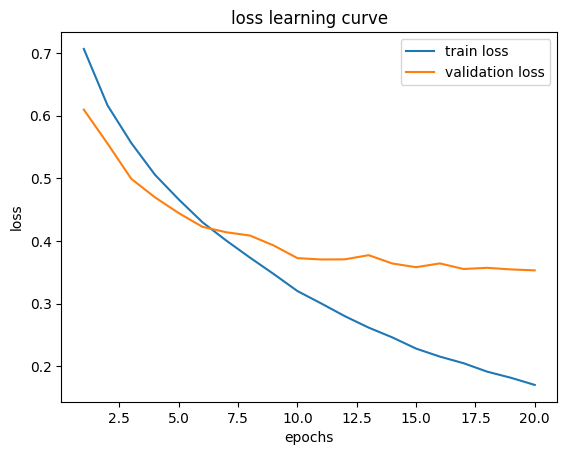

In [73]:
epochs = range(1,len(histories['train_loss']) + 1)
plt.plot(epochs, histories['train_loss'], label = 'train loss')
plt.plot(epochs, histories['val_loss'], label = 'validation loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss learning curve')